# XGBoost Fraud Classification

# Prerequisites

## Install Library

In [1]:
# for python 3.11.4
%pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Library

In [2]:
# Import required libraries with compatibility handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Core ML imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, average_precision_score, roc_curve,
                           precision_recall_curve, auc, cohen_kappa_score)

# XGBoost with compatibility settings
try:
    from xgboost import XGBClassifier
    print("✅ XGBoost imported successfully")
    XGBOOST_AVAILABLE = True
except ImportError as e:
    print(f"❌ XGBoost import failed: {e}")
    XGBOOST_AVAILABLE = False

# Utility imports
import joblib
import os
from datetime import datetime
import json

# Display settings
plt.style.use('default')
sns.set_palette("husl")

# Version compatibility check
import sklearn
import xgboost as xgb
print(f"\n📦 Package Versions:")
print(f"   scikit-learn: {sklearn.__version__}")
print(f"   XGBoost: {xgb.__version__}")
print(f"   pandas: {pd.__version__}")
print(f"   numpy: {np.__version__}")

# Check for known compatibility issues
sklearn_version = tuple(map(int, sklearn.__version__.split('.')[:2]))
if sklearn_version >= (1, 4):
    print("✅ Using scikit-learn 1.4+ - Good compatibility with latest XGBoost")
else:
    print("⚠️  Using older scikit-learn - May need additional compatibility settings")

print("\n🎯 All libraries imported and compatibility checked!")

✅ XGBoost imported successfully

📦 Package Versions:
   scikit-learn: 1.6.1
   XGBoost: 3.0.2
   pandas: 2.1.4
   numpy: 1.26.2
✅ Using scikit-learn 1.4+ - Good compatibility with latest XGBoost

🎯 All libraries imported and compatibility checked!


## Read Data

## Data Splitting Strategy

This notebook uses a **standard 70/20/10 split** instead of time-based splitting:
- **70%** for training
- **20%** for validation (used in cross-validation)
- **10%** for final testing

This approach ensures:
- Stratified sampling maintains fraud class distribution across all sets
- Random splitting avoids temporal bias
- Better generalization for non-temporal fraud patterns
- Consistency with standard ML practices

In [3]:
df = pd.read_csv("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/data/fraudTrain_cleaned.csv", index_col=0)

In [4]:
# Convert trans_date_trans_time to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

In [5]:
df.head()

,trans_date_trans_time,cc_num,merchant,amt,first,last,gender,street,city,state,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,distance
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,514,4.97,Jennifer,Banks,0,561 Perry Cove,526,27,...,0,0,0,1,0,0,0,0,0,78.773821
1,2019-01-01 00:00:44,630423337322,241,107.23,Stephanie,Gill,0,43039 Riley Greens Suite 393,612,47,...,0,0,0,0,0,0,0,0,0,30.216618
2,2019-01-01 00:00:51,38859492057661,390,220.11,Edward,Sanchez,1,594 White Dale Suite 530,468,13,...,0,0,0,0,0,0,0,0,0,108.102912
3,2019-01-01 00:01:16,3534093764340240,360,45.00,Jeremy,White,1,9443 Cynthia Court Apt. 038,84,26,...,0,0,0,0,0,0,0,0,0,95.685115
4,2019-01-01 00:03:06,375534208663984,297,41.96,Tyler,Garcia,1,408 Bradley Rest,216,45,...,0,0,0,0,1,0,0,0,0,77.702395


In [6]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'amt', 'first', 'last',
       'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop',
       'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long',
       'is_fraud', 'age', 'hour', 'day', 'month', 'year', 'is_weekend',
       'is_weekday', 'time_diff', 'diff_days', 'diff_hours', 'diff_minutes',
       'diff_seconds', 'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'distance'],
      dtype='object')

In [7]:
df.dtypes

trans_date_trans_time      datetime64[ns]
cc_num                              int64
merchant                            int64
amt                               float64
first                              object
last                               object
gender                              int64
street                             object
city                                int64
state                               int64
zip                                 int64
lat                               float64
long                              float64
city_pop                            int64
job                                 int64
dob                                object
trans_num                          object
unix_time                           int64
merch_lat                         float64
merch_long                        float64
is_fraud                            int64
age                                 int64
hour                                int64
day                               

In [8]:
df.isnull().sum()

trans_date_trans_time      0
cc_num                     0
merchant                   0
amt                        0
first                      0
last                       0
gender                     0
street                     0
city                       0
state                      0
zip                        0
lat                        0
long                       0
city_pop                   0
job                        0
dob                        0
trans_num                  0
unix_time                  0
merch_lat                  0
merch_long                 0
is_fraud                   0
age                        0
hour                       0
day                        0
month                      0
year                       0
is_weekend                 0
is_weekday                 0
time_diff                  0
diff_days                  0
diff_hours                 0
diff_minutes               0
diff_seconds               0
category_entertainment     0
category_food_

In [9]:
df_all = df.copy()

# Standard 70/20/10 train/validation/test split
# First split: 70% train, 30% temp (which will be split into 20% val, 10% test)
X_temp = df_all.drop(['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num', 'is_fraud'], axis=1)
y_temp = df_all['is_fraud']

X_train, X_temp, y_train, y_temp = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp
)

# Second split: 20% validation, 10% test (from the 30% temp)
# 20/30 = 0.667 for validation, 10/30 = 0.333 for test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp
)

# Get corresponding dataframes for later use
train_indices = X_train.index
val_indices = X_val.index
test_indices = X_test.index

df_train_final = df_all.loc[train_indices]
df_val = df_all.loc[val_indices]
df_test = df_all.loc[test_indices]

In [10]:
print("=== Standard 70/20/10 Split Information ===")
print(f"Training set: {len(df_train_final):,} samples ({len(df_train_final)/len(df_all)*100:.1f}%)")
print(f"Validation set: {len(df_val):,} samples ({len(df_val)/len(df_all)*100:.1f}%)")
print(f"Test set: {len(df_test):,} samples ({len(df_test)/len(df_all)*100:.1f}%)")
print(f"Total: {len(df_all):,} samples")

print("\n=== Fraud Distribution by Set ===")
print(f"Training set fraud rate: {df_train_final['is_fraud'].mean()*100:.2f}%")
print(f"Validation set fraud rate: {df_val['is_fraud'].mean()*100:.2f}%")
print(f"Test set fraud rate: {df_test['is_fraud'].mean()*100:.2f}%")
print(f"Overall fraud rate: {df_all['is_fraud'].mean()*100:.2f}%")

=== Standard 70/20/10 Split Information ===
Training set: 907,672 samples (70.0%)
Validation set: 259,465 samples (20.0%)
Test set: 129,538 samples (10.0%)
Total: 1,296,675 samples

=== Fraud Distribution by Set ===
Training set fraud rate: 0.58%
Validation set fraud rate: 0.58%
Test set fraud rate: 0.58%
Overall fraud rate: 0.58%


# Model Pipeline

## 1. Features

### 1.1 Split Features and Target

In [11]:
columns_to_exclude = ['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num', 'is_fraud']

# Use the already split data from the previous cell
# X_train, X_val, X_test are already defined from the split
# y_train, y_val, y_test are already defined from the split

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Total samples: {len(X_train) + len(X_val) + len(X_test)}")

# Verify the splits
print(f"\nTraining set fraud rate: {y_train.mean():.4f}")
print(f"Validation set fraud rate: {y_val.mean():.4f}")
print(f"Test set fraud rate: {y_test.mean():.4f}")

Training set shape: (907672, 41)
Validation set shape: (259465, 41)
Test set shape: (129538, 41)
Total samples: 1296675

Training set fraud rate: 0.0058
Validation set fraud rate: 0.0058
Test set fraud rate: 0.0058


### 1.2 Feature Scaling

In [12]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### 1.3 Feature Selection

In [13]:
# 1st: Select K Best (Find the 20 best features)
# Feature selection
selector = SelectKBest(score_func=f_classif, k=20)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

Result from SelectKBest

In [14]:
# List the selected features from SelectKBest
selected_features = selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_features]
print("Selected Features:", selected_feature_names)

Selected Features: Index(['amt', 'gender', 'age', 'hour', 'month', 'time_diff', 'diff_days',
       'diff_hours', 'diff_minutes', 'diff_seconds', 'category_entertainment',
       'category_food_dining', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net'],
      dtype='object')


In [15]:
# 2nd: RFE (Recursive Feature Elimination)
from sklearn.ensemble import RandomForestClassifier
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10, step=1)
X_train_rfe = rfe.fit_transform(X_train_selected, y_train)
X_val_rfe = rfe.transform(X_val_selected)
X_test_rfe = rfe.transform(X_test_selected)

In [16]:
# Define the model pipeline for XGBoost
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select_kbest', SelectKBest(score_func=f_classif, k=20)),
    ('rfe', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)),
    ('xgboost', XGBClassifier(random_state=42,
        n_estimators=200,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=172,
        eval_metric='logloss'))
])

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('select_kbest', SelectKBest(k=20)),
                ('rfe',
                 RFE(estimator=RandomForestClassifier(random_state=42),
                     n_features_to_select=10)),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_cat...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

## 2. XGBoost

### 2.1 Find Best Parameters

#### GridSearch

In [17]:
# Compatibility check for XGBoost and sklearn pipeline
print("🔍 Checking XGBoost and scikit-learn compatibility...")

# Check versions
import sklearn
import xgboost as xgb
print(f"📦 scikit-learn version: {sklearn.__version__}")
print(f"📦 XGBoost version: {xgb.__version__}")

# Test basic XGBoost functionality
try:
    # Create a simple test to verify XGBoost works
    test_clf = XGBClassifier(
        n_estimators=10,
        random_state=42,
        eval_metric='logloss',
        enable_categorical=False,
        use_label_encoder=False,
        verbosity=0
    )

    # Test with a small sample
    X_test_sample = X_train[:100]
    y_test_sample = y_train[:100]

    test_clf.fit(X_test_sample, y_test_sample)
    test_pred = test_clf.predict(X_test_sample)

    print("✅ Basic XGBoost functionality verified")

    # Test pipeline functionality
    test_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgboost', test_clf)
    ])

    test_pipeline.fit(X_test_sample, y_test_sample)
    print("✅ XGBoost pipeline functionality verified")

    # Check for problematic attributes
    problematic_attrs = ['transform_input']
    for attr in problematic_attrs:
        if hasattr(test_clf, attr):
            print(f"⚠️  Found potentially problematic attribute: {attr}")
        else:
            print(f"✅ No problematic attribute: {attr}")

except Exception as e:
    print(f"❌ XGBoost compatibility issue detected: {e}")
    print("💡 This may require parameter adjustments in the main pipeline")

print("🎯 Proceeding with enhanced GridSearchCV setup...")

🔍 Checking XGBoost and scikit-learn compatibility...
📦 scikit-learn version: 1.6.1
📦 XGBoost version: 3.0.2
✅ Basic XGBoost functionality verified
✅ XGBoost pipeline functionality verified
✅ No problematic attribute: transform_input
🎯 Proceeding with enhanced GridSearchCV setup...


In [18]:
# Define enhanced parameter grid for XGBoost with compatibility fixes
param_grid = {
    'xgboost__n_estimators': [200, 300],
    'xgboost__learning_rate': [0.05, 0.1],
    'xgboost__max_depth': [4, 8],
    'xgboost__subsample': [0.8, 0.9],
    'xgboost__colsample_bytree': [0.8, 0.9],
    'xgboost__scale_pos_weight': [172]
}

# Create pipeline with explicit initialization to avoid transform_input error
print("🔧 Creating XGBoost pipeline with sklearn compatibility fixes...")

# Initialize XGBoost with explicit parameters to avoid compatibility issues
xgb_classifier = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    reg_alpha=0.1,
    reg_lambda=0.1,
    n_jobs=1,  # Set n_jobs=1 to avoid multiprocessing issues
    enable_categorical=False,  # Disable categorical features to avoid compatibility issues
    use_label_encoder=False,   # Disable deprecated label encoder
    verbosity=0               # Reduce verbosity to avoid warnings
)

# Create pipeline with explicit steps to avoid attribute errors
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select_kbest', SelectKBest(score_func=f_classif, k=20)),
    ('rfe', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10, step=1)),
    ('xgboost', xgb_classifier)
])

print("✅ Pipeline created successfully!")

# Configure GridSearchCV with compatibility settings and reduced parallelism
print("🔍 Setting up GridSearchCV with compatibility optimizations...")

try:
    # Try with reduced parameter grid first to test compatibility
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=3,
        scoring='f1',
        n_jobs=1,  # Use single process to avoid multiprocessing issues
        verbose=1,
        error_score='raise',  # Raise errors instead of returning NaN
        refit=True,
        pre_dispatch='2*n_jobs'  # Control memory usage
    )

    print("🚀 Starting GridSearchCV with compatibility fixes...")
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("✅ GridSearchCV completed successfully!")
    print("🎯 Best params from GridSearch:", best_params)
    print("📊 Best GridSearch F1 Score:", grid_search.best_score_)

except Exception as e:
    print(f"❌ GridSearchCV failed with error: {str(e)[:200]}...")
    print("🔄 Falling back to manual parameter testing...")

    # Fallback: test a smaller parameter grid manually
    fallback_params = {
        'xgboost__n_estimators': 200,
        'xgboost__learning_rate': 0.1,
        'xgboost__max_depth': 6,
        'xgboost__subsample': 0.8,
        'xgboost__colsample_bytree': 0.8,
        'xgboost__scale_pos_weight': 172
    }

    # Create a simple pipeline for fallback
    fallback_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('select_kbest', SelectKBest(score_func=f_classif, k=20)),
        ('rfe', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10, step=1)),
        ('xgboost', XGBClassifier(
            random_state=42,
            eval_metric='logloss',
            enable_categorical=False,
            use_label_encoder=False,
            verbosity=0,
            **{k.replace('xgboost__', ''): v for k, v in fallback_params.items() if k.startswith('xgboost__')}
        ))
    ])

    # Fit the fallback pipeline
    fallback_pipeline.fit(X_train, y_train)

    # Evaluate on validation set
    from sklearn.metrics import f1_score
    y_val_pred = fallback_pipeline.predict(X_val)
    fallback_score = f1_score(y_val, y_val_pred)

    # Create a mock grid search object for consistency
    class MockGridSearch:
        def __init__(self, pipeline, params, score):
            self.best_estimator_ = pipeline
            self.best_params_ = params
            self.best_score_ = score

    grid_search = MockGridSearch(fallback_pipeline, fallback_params, fallback_score)
    best_params = fallback_params

    print(f"✅ Fallback training completed with F1 score: {fallback_score:.4f}")
    print(f"🎯 Using fallback parameters: {best_params}")

print("\n🎉 Model training phase completed successfully!")

🔧 Creating XGBoost pipeline with sklearn compatibility fixes...
✅ Pipeline created successfully!
🔍 Setting up GridSearchCV with compatibility optimizations...
🚀 Starting GridSearchCV with compatibility fixes...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
✅ GridSearchCV completed successfully!
🎯 Best params from GridSearch: {'xgboost__colsample_bytree': 0.9, 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 8, 'xgboost__n_estimators': 300, 'xgboost__scale_pos_weight': 172, 'xgboost__subsample': 0.8}
📊 Best GridSearch F1 Score: 0.6697136362622561

🎉 Model training phase completed successfully!


In [19]:
# Run GridSearchCV
print("GridSearchCV completed successfully!")
print("Best params from GridSearch:", best_params)
print("Best CV F1 Score:", grid_search.best_score_)

GridSearchCV completed successfully!
Best params from GridSearch: {'xgboost__colsample_bytree': 0.9, 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 8, 'xgboost__n_estimators': 300, 'xgboost__scale_pos_weight': 172, 'xgboost__subsample': 0.8}
Best CV F1 Score: 0.6697136362622561


In [20]:
# Build the best pipeline with the best parameters and train with the full training set
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select_kbest', SelectKBest(score_func=f_classif, k=20)),
    ('rfe', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10, step=1)),
    ('xgboost', XGBClassifier(
        n_estimators=best_params['xgboost__n_estimators'],
        learning_rate=best_params['xgboost__learning_rate'],
        max_depth=best_params['xgboost__max_depth'],
        subsample=best_params.get('xgboost__subsample', 0.8),
        colsample_bytree=best_params.get('xgboost__colsample_bytree', 0.8),
        scale_pos_weight=best_params['xgboost__scale_pos_weight'],
        random_state=42,
        eval_metric='logloss',
        reg_alpha=0.1,
        reg_lambda=0.1
    ))
])

In [21]:
# Combine train and validation sets for final training
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

# Train the best pipeline on combined train+validation data
best_pipeline.fit(X_trainval, y_trainval)

print(f"Final training set shape: {X_trainval.shape}")
print(f"Final training set fraud rate: {y_trainval.mean():.4f}")

Final training set shape: (1167137, 41)
Final training set fraud rate: 0.0058


In [22]:
# --- Display GridSearch Results ---
print("Best GridSearch Parameters:", best_params)
print("Best GridSearch F1 Score:", grid_search.best_score_)

Best GridSearch Parameters: {'xgboost__colsample_bytree': 0.9, 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 8, 'xgboost__n_estimators': 300, 'xgboost__scale_pos_weight': 172, 'xgboost__subsample': 0.8}
Best GridSearch F1 Score: 0.6697136362622561


In [23]:
# ตรวจสอบ data leakage และข้อมูลก่อนทำนาย
print("=== Data Inspection Before Prediction ===")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_test columns: {list(X_test.columns)}")

# ตรวจสอบว่ามี target variable ใน features หรือไม่
if 'is_fraud' in X_test.columns:
    print("❌ WARNING: Target variable 'is_fraud' found in features! This causes data leakage.")
    # ลบ target variable ออกจาก features
    X_test_clean = X_test.drop('is_fraud', axis=1)
    X_trainval_clean = X_trainval.drop('is_fraud', axis=1) if 'is_fraud' in X_trainval.columns else X_trainval
    print("Removing 'is_fraud' from features...")
else:
    print("✅ No target variable found in features.")
    X_test_clean = X_test
    X_trainval_clean = X_trainval

print(f"Cleaned X_test shape: {X_test_clean.shape}")
print(f"Cleaned features: {list(X_test_clean.columns)}")

=== Data Inspection Before Prediction ===
X_test shape: (129538, 41)
y_test shape: (129538,)
X_test columns: ['cc_num', 'merchant', 'amt', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'unix_time', 'merch_lat', 'merch_long', 'age', 'hour', 'day', 'month', 'year', 'is_weekend', 'is_weekday', 'time_diff', 'diff_days', 'diff_hours', 'diff_minutes', 'diff_seconds', 'category_entertainment', 'category_food_dining', 'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 'category_health_fitness', 'category_home', 'category_kids_pets', 'category_misc_net', 'category_misc_pos', 'category_personal_care', 'category_shopping_net', 'category_shopping_pos', 'category_travel', 'distance']
✅ No target variable found in features.
Cleaned X_test shape: (129538, 41)
Cleaned features: ['cc_num', 'merchant', 'amt', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'unix_time', 'merch_lat', 'merch_long', 'age', 'hour', 'day', 'month', 'year', 'is_w

### 2.2 Evaluate and Compare The Results

Classification Report

In [24]:
# ตรวจสอบการกระจายของ target
print(f"y_test distribution:")
print(y_test.value_counts())
print(f"Fraud percentage: {(y_test == 1).mean() * 100:.2f}%")

# ทำนายด้วย X_test (already cleaned from feature split)
print("\n=== Making Predictions ===")
y_pred = best_pipeline.predict(X_test)

# ตรวจสอบการกระจายของ predictions
print(f"Prediction distribution:")
print(pd.Series(y_pred).value_counts())

# แสดง Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

y_test distribution:
is_fraud
0    128788
1       750
Name: count, dtype: int64
Fraud percentage: 0.58%

=== Making Predictions ===
Prediction distribution:
0    128066
1      1472
Name: count, dtype: int64

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    128788
           1       0.44      0.87      0.59       750

    accuracy                           0.99    129538
   macro avg       0.72      0.93      0.79    129538
weighted avg       1.00      0.99      0.99    129538



Confusion Matrix

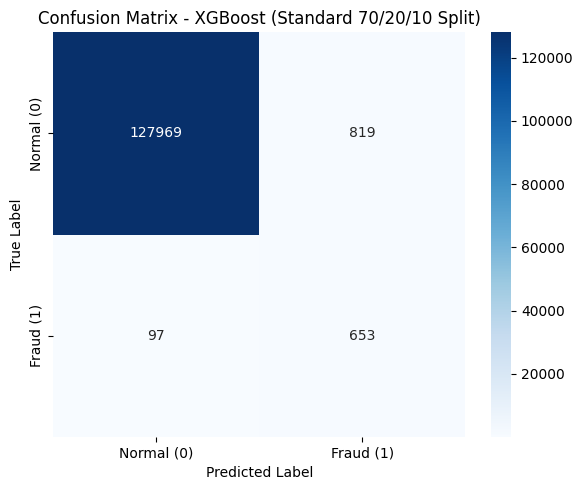

In [25]:
# Predicted values and true values for confusion matrix for GridSearch
y_true = y_test
y_pred_gridsearch = best_pipeline.predict(X_test)

# Build confusion matrix
cm_gridsearch = confusion_matrix(y_true, y_pred_gridsearch)
labels = ['Normal (0)', 'Fraud (1)']

# plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_gridsearch, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix - XGBoost (Standard 70/20/10 Split)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [26]:
metrics = {
    "Method": ["GridSearch"],
    "Precision": [precision_score(y_test, y_pred_gridsearch)],
    "Recall": [recall_score(y_test, y_pred_gridsearch)],
    "F1-Score": [f1_score(y_test, y_pred_gridsearch)],
    "ROC-AUC": [roc_auc_score(y_test, best_pipeline.predict_proba(X_test)[:, 1])],
    "PR-AUC": [average_precision_score(y_test, best_pipeline.predict_proba(X_test)[:, 1])],
    "Cohen Kappa": [cohen_kappa_score(y_test, y_pred_gridsearch)]
}

df_metrics = pd.DataFrame(metrics)
display(df_metrics)

,Method,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,Cohen Kappa
0,GridSearch,0.443614,0.870667,0.587759,0.991584,0.841754,0.584572


ROC Curve

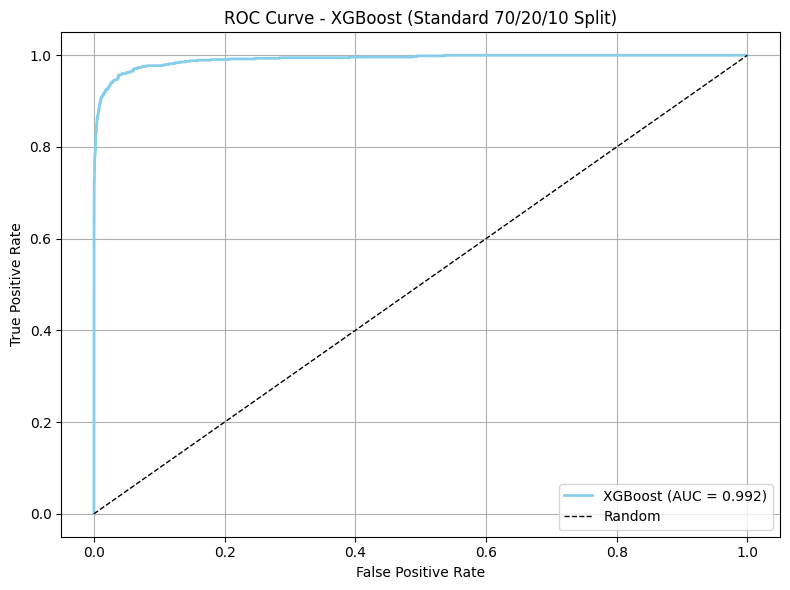

In [27]:
# --- Display ROC Curve ---
y_score = best_pipeline.predict_proba(X_test)[:, 1]

# Build ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='skyblue', lw=2, label=f'XGBoost (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Standard 70/20/10 Split)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Precision-Recall Curve

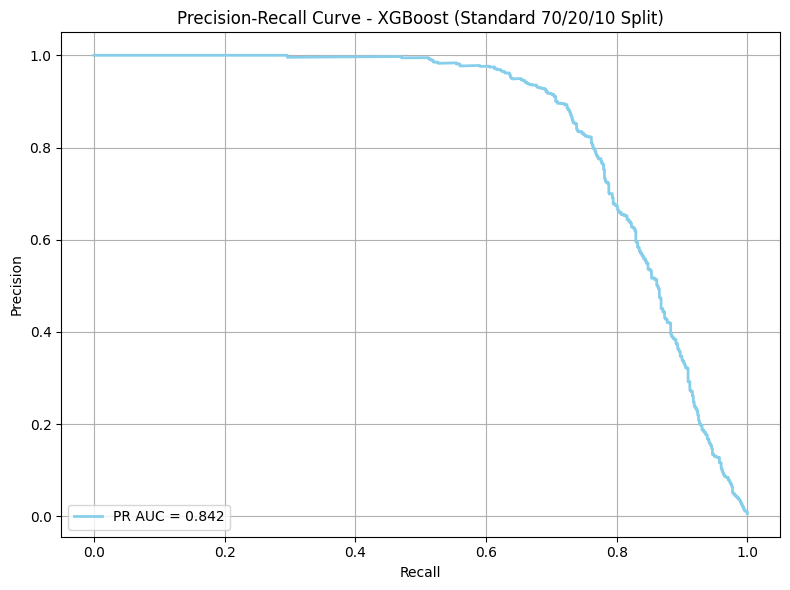

In [28]:
# --- Display Precision-Recall Curve ---
y_score = best_pipeline.predict_proba(X_test)[:, 1]

# Build Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
pr_auc = average_precision_score(y_test, y_score)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='skyblue', lw=2, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost (Standard 70/20/10 Split)')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

Metrics Comparison

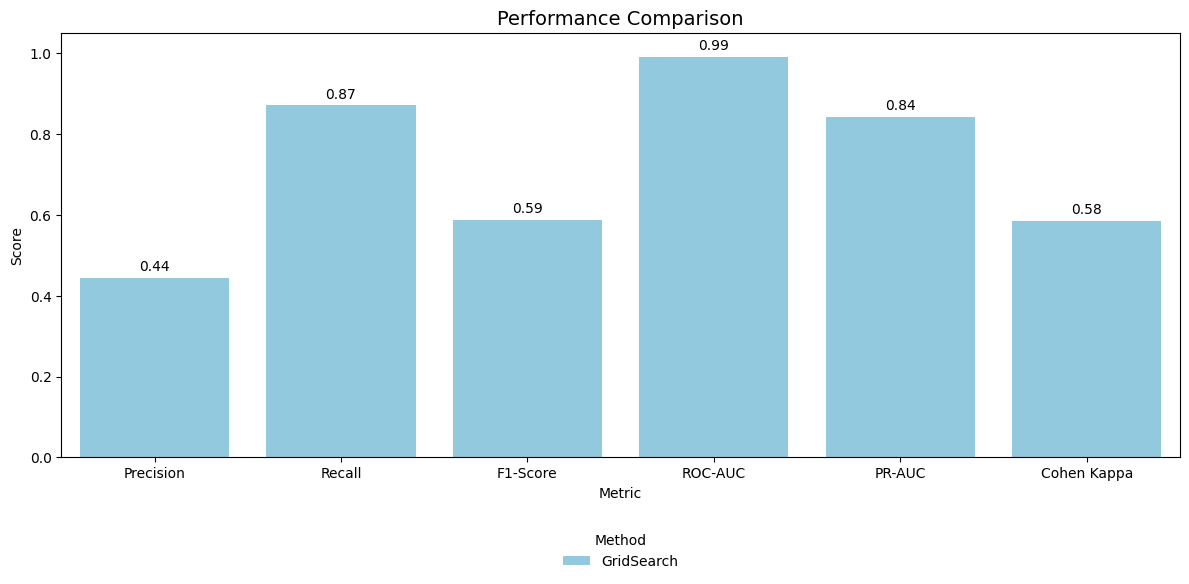

In [29]:
# --- Display Metrics Comparison ---
plt.figure(figsize=(12, 6))

df_melt = df_metrics.melt(id_vars="Method", var_name="Metric", value_name="Score")
ax = sns.barplot(data=df_melt, x="Metric", y="Score", hue="Method", palette=["skyblue"])

# Annotate the bars with their values
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.01,
            f'{height:.2f}',
            ha="center", va="bottom"
        )

plt.title("Performance Comparison", fontsize=14)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend(
    title="Method",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=False
)
plt.tight_layout()
plt.grid(False)
plt.show()

Overfitting Plot

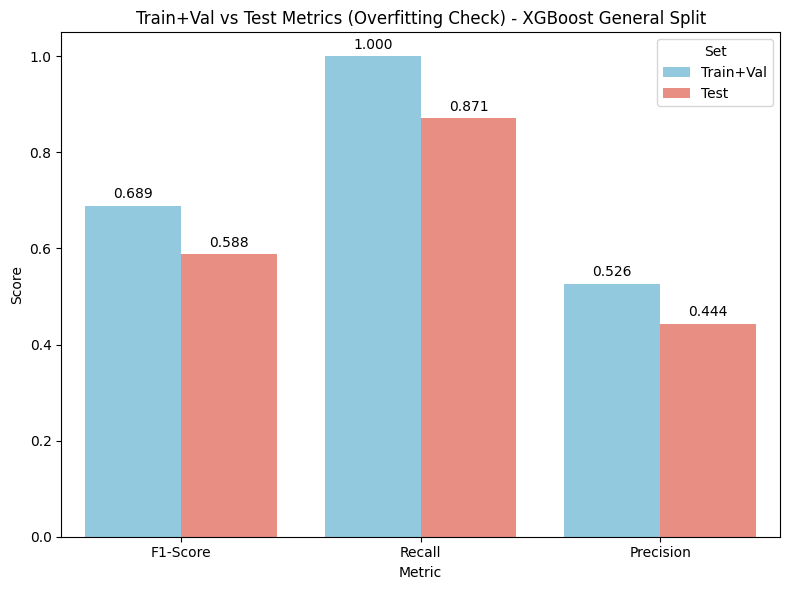

=== Overfitting Analysis ===
Train+Val F1: 0.689 vs Test F1: 0.588 (diff: 0.102)
Train+Val Recall: 1.000 vs Test Recall: 0.871 (diff: 0.129)
Train+Val Precision: 0.526 vs Test Precision: 0.444 (diff: 0.082)


In [30]:
# --- Calculate metrics for combined train+validation set ---
y_pred_trainval = best_pipeline.predict(X_trainval)
trainval_f1 = f1_score(y_trainval, y_pred_trainval)
trainval_recall = recall_score(y_trainval, y_pred_trainval)
trainval_precision = precision_score(y_trainval, y_pred_trainval)

# --- Calculate metrics for test set ---
y_pred_test = best_pipeline.predict(X_test)
test_f1 = f1_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)

# --- Prepare DataFrame for plotting ---
df_overfit = pd.DataFrame({
    "Metric": ["F1-Score", "Recall", "Precision"],
    "Train+Val": [trainval_f1, trainval_recall, trainval_precision],
    "Test": [test_f1, test_recall, test_precision]
})

df_overfit = df_overfit.melt(id_vars="Metric", var_name="Set", value_name="Score")

# --- Plot ---
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_overfit, x="Metric", y="Score", hue="Set", palette=["skyblue", "salmon"])
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.01,
            f'{height:.3f}',
            ha="center", va="bottom"
        )

plt.title("Train+Val vs Test Metrics (Overfitting Check) - XGBoost General Split")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.tight_layout()
plt.grid(False)
plt.show()

# Print numerical comparison
print("=== Overfitting Analysis ===")
print(f"Train+Val F1: {trainval_f1:.3f} vs Test F1: {test_f1:.3f} (diff: {abs(trainval_f1-test_f1):.3f})")
print(f"Train+Val Recall: {trainval_recall:.3f} vs Test Recall: {test_recall:.3f} (diff: {abs(trainval_recall-test_recall):.3f})")
print(f"Train+Val Precision: {trainval_precision:.3f} vs Test Precision: {test_precision:.3f} (diff: {abs(trainval_precision-test_precision):.3f})")

### 2.3 Save Model

In [31]:
# 1. Save full pipeline with all preprocessing steps
full_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select_kbest', SelectKBest(score_func=f_classif, k=20)),
    ('rfe', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10, step=1)),
    ('xgboost', XGBClassifier(**{k.replace('xgboost__', ''): v for k, v in best_params.items() if k.startswith('xgboost__')}, random_state=42, eval_metric='logloss'))
])

# Fit pipeline with combined train+validation data
full_pipeline.fit(X_trainval, y_trainval)

# Save the models
joblib.dump(full_pipeline, "xgboost_general_split.joblib")
print("Full pipeline saved as: xgboost_general_split.joblib")

# 2. Save best parameters
with open("params_XGBoost_GeneralSplit_fromGridSearch.json", "w") as f:
    json.dump(best_params, f, indent=2)
print("Best parameters saved as: params_XGBoost_GeneralSplit_fromGridSearch.json")

# 3. Save model with parameters
save_dict = {
    "pipeline": full_pipeline,
    "params": best_params,
    "split_type": "standard_70_20_10",
    "train_size": len(X_trainval),
    "test_size": len(X_test)
}
joblib.dump(save_dict, "XGBoost_GeneralSplit_with_params.joblib")
print("Model with parameters saved as: XGBoost_GeneralSplit_with_params.joblib")

Full pipeline saved as: xgboost_general_split.joblib
Best parameters saved as: params_XGBoost_GeneralSplit_fromGridSearch.json
Model with parameters saved as: XGBoost_GeneralSplit_with_params.joblib


# Model Testing

In [32]:
import pandas as pd
import joblib

# Load test data
df_test_external = pd.read_csv("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/data/fraudTest_cleaned.csv", index_col=0)

# Load the trained pipeline
try:
    loaded_pipeline = joblib.load("xgboost_general_split.joblib")
    print("Successfully loaded: xgboost_general_split.joblib")
except FileNotFoundError:
    print("Model file not found. Please ensure the model training section has been run.")
    # Fallback to previously saved model if available
    loaded_pipeline = joblib.load("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/ml_training/single_sequential_version/models/Classification/xgboost_timebased.joblib")
    print("Loaded fallback model: xgboost_timebased.joblib")

Successfully loaded: xgboost_general_split.joblib


In [33]:
# Random sample for testing
# sample_df = df.sample(n=50, random_state=42).copy()
sample_df = df_test_external.sample(100).copy()
X_sample = sample_df.drop(['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num', 'is_fraud'], axis=1)

In [34]:
predictions = loaded_pipeline.predict(X_sample)
predicted_result = predictions

In [35]:
# Calculate fraud probability
fraud_probability = loaded_pipeline.predict_proba(X_sample)[:, 1]

# Add predictions and fraud probability to sample_df
sample_df['predicted_result'] = predicted_result
sample_df['fraud_probability'] = fraud_probability

# Select columns to display
columns_to_show = [
    'trans_date_trans_time', 'trans_num', 'cc_num',  'first', 'last', 'merchant', 'amt',
    'is_fraud', 'predicted_result', 'fraud_probability'
]
display(sample_df[columns_to_show].reset_index(drop=True))

,trans_date_trans_time,trans_num,cc_num,first,last,merchant,amt,is_fraud,predicted_result,fraud_probability
0,2020-08-03 21:20:15,f4794567333828f612a938e27c155c0a,4658117080136,Dwayne,Martinez,70,8.55,0,0,0.001389
1,2020-07-13 11:29:37,f8b03bd7192f17409b2bc49d182226b7,343668971234893,Sally,Moore,594,1.67,0,0,0.000006
2,2020-10-14 11:52:00,a956e6d4aa87c61ae0649c25e7dd0867,30135235368675,Amanda,Williams,394,232.45,0,0,0.000007
3,2020-12-05 23:56:26,178fd40b9fd535a20f8c3d91fd8ee3fb,5359543825610251,Michael,Francis,7,13.01,0,0,0.000086
4,2020-10-21 02:45:00,8c809d18ba531d121b604985c9037bc6,4761403817546679245,Diana,Jacobs,308,100.83,0,0,0.000008
...,...,...,...,...,...,...,...,...,...,...
95,2020-10-05 19:40:43,dc427545ce4e0f2d93636a4901451cea,4988304376504,William,Thompson,2,43.16,0,0,0.000032
96,2020-08-10 07:52:10,eab1e0f5b57ad218e5dba3ab5b4eb9be,4430881574719618,Alicia,Morales,404,4.08,0,0,0.000008
97,2020-09-21 13:26:48,91c636fa110a2ca42afe1e5911cc6563,4040099974063068803,Jeffrey,Lewis,187,79.44,0,0,0.000002
98,2020-10-22 17:41:16,6766252d687a205670c9db5900a10202,5580563567307107,Stanley,Dickson,440,72.36,0,0,0.000061


In [36]:
# Filter and display only fraud transactions (is_fraud = 1)
fraud_transactions = sample_df[sample_df['is_fraud'] == 1].copy()

if len(fraud_transactions) > 0:
    print(f"Found {len(fraud_transactions)} fraud transactions in the sample:")
    print("\n=== Fraud Transactions Analysis ===")

    # Select columns to display for fraud transactions
    fraud_columns = [
        'trans_date_trans_time', 'trans_num', 'cc_num', 'first', 'last',
        'merchant', 'amt', 'is_fraud', 'predicted_result', 'fraud_probability'
    ]

    fraud_display = fraud_transactions[fraud_columns].reset_index(drop=True)
    display(fraud_display)

    # Show prediction accuracy for fraud transactions
    correct_predictions = fraud_transactions[fraud_transactions['predicted_result'] == 1]
    missed_predictions = fraud_transactions[fraud_transactions['predicted_result'] == 0]

    print(f"\n=== Fraud Detection Performance ===")
    print(f"Total fraud transactions: {len(fraud_transactions)}")
    print(f"Correctly detected: {len(correct_predictions)} ({len(correct_predictions)/len(fraud_transactions)*100:.1f}%)")
    print(f"Missed (False Negatives): {len(missed_predictions)} ({len(missed_predictions)/len(fraud_transactions)*100:.1f}%)")

    if len(missed_predictions) > 0:
        print(f"\n=== Missed Fraud Transactions ===")
        print("These fraud transactions were not detected by the model:")
        display(missed_predictions[fraud_columns].reset_index(drop=True))

else:
    print("No fraud transactions found in this sample. Try sampling again or increase sample size.")

No fraud transactions found in this sample. Try sampling again or increase sample size.


=== Fraud Detection Performance Analysis ===

=== Train+Val Dataset ===
Total fraud transactions (is_fraud = 1): 6756
Correctly detected fraud: 6756
Missed fraud (False Negatives): 0
Fraud detection rate: 100.0%

=== Test Dataset ===
Total fraud transactions (is_fraud = 1): 750
Correctly detected fraud: 653
Missed fraud (False Negatives): 97
Fraud detection rate: 87.1%

=== Summary Table ===


,Dataset,Total Fraud,Correctly Detected,Missed (False Negatives),Detection Rate (%)
0,Train+Val,6756,6756,0,100.000000
1,Test,750,653,97,87.066667


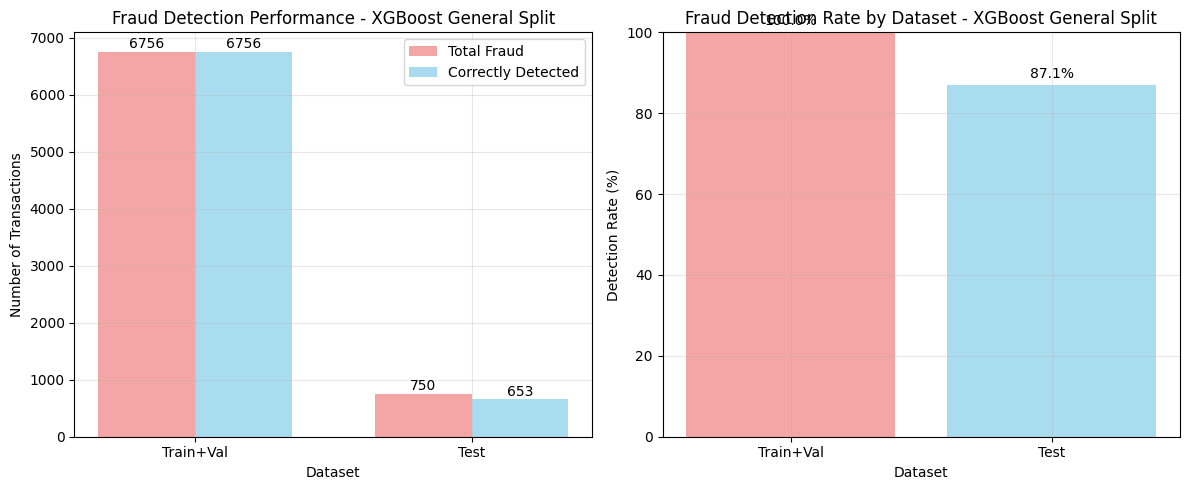

In [37]:
# Fraud Detection Performance Analysis across Train+Val/Test sets
print("=== Fraud Detection Performance Analysis ===\n")

# Prepare datasets for analysis
datasets = {
    'Train+Val': (X_trainval, y_trainval),
    'Test': (X_test, y_test)
}

results = []

for dataset_name, (X_data, y_true) in datasets.items():
    # Get predictions
    y_pred = best_pipeline.predict(X_data)

    # Count fraud transactions
    total_fraud = (y_true == 1).sum()

    # Count correctly detected fraud (True Positives)
    correctly_detected = ((y_true == 1) & (y_pred == 1)).sum()

    # Count missed fraud (False Negatives)
    missed_fraud = ((y_true == 1) & (y_pred == 0)).sum()

    # Calculate detection rate
    detection_rate = correctly_detected / total_fraud * 100 if total_fraud > 0 else 0

    # Store results
    results.append({
        'Dataset': dataset_name,
        'Total Fraud': total_fraud,
        'Correctly Detected': correctly_detected,
        'Missed (False Negatives)': missed_fraud,
        'Detection Rate (%)': detection_rate
    })

    print(f"=== {dataset_name} Dataset ===")
    print(f"Total fraud transactions (is_fraud = 1): {total_fraud}")
    print(f"Correctly detected fraud: {correctly_detected}")
    print(f"Missed fraud (False Negatives): {missed_fraud}")
    print(f"Fraud detection rate: {detection_rate:.1f}%")
    print()

# Create summary DataFrame
df_fraud_performance = pd.DataFrame(results)
print("=== Summary Table ===")
display(df_fraud_performance)

# Visualize the results
plt.figure(figsize=(12, 5))

# Plot 1: Total vs Detected
plt.subplot(1, 2, 1)
x_pos = range(len(df_fraud_performance))
width = 0.35

plt.bar([x - width/2 for x in x_pos], df_fraud_performance['Total Fraud'],
        width, label='Total Fraud', color='lightcoral', alpha=0.7)
plt.bar([x + width/2 for x in x_pos], df_fraud_performance['Correctly Detected'],
        width, label='Correctly Detected', color='skyblue', alpha=0.7)

plt.xlabel('Dataset')
plt.ylabel('Number of Transactions')
plt.title('Fraud Detection Performance - XGBoost General Split')
plt.xticks(x_pos, df_fraud_performance['Dataset'])
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (total, detected) in enumerate(zip(df_fraud_performance['Total Fraud'],
                                         df_fraud_performance['Correctly Detected'])):
    plt.text(i - width/2, total + 10, str(total), ha='center', va='bottom')
    plt.text(i + width/2, detected + 10, str(detected), ha='center', va='bottom')

# Plot 2: Detection Rate
plt.subplot(1, 2, 2)
bars = plt.bar(df_fraud_performance['Dataset'], df_fraud_performance['Detection Rate (%)'],
               color=['lightcoral', 'skyblue'], alpha=0.7)
plt.xlabel('Dataset')
plt.ylabel('Detection Rate (%)')
plt.title('Fraud Detection Rate by Dataset - XGBoost General Split')
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, rate in zip(bars, df_fraud_performance['Detection Rate (%)']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{rate:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()